In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.2)
sns.set_style("white")

In [2]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [3]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
web1["vnf"] = "nginx"
web2["vnf"] = "haproxy"
web3["vnf"] = "squid"

mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
# select sub-datasets with small and large flows
web1_small = web1.loc[web1["size"] == "small"]
web1_big = web1.loc[web1["size"] == "big"]

web2_small = web2.loc[web2["size"] == "small"]
web2_big = web2.loc[web2["size"] == "big"]

web3_small = web3.loc[web3["size"] == "small"]
web3_big = web3.loc[web3["size"] == "big"]

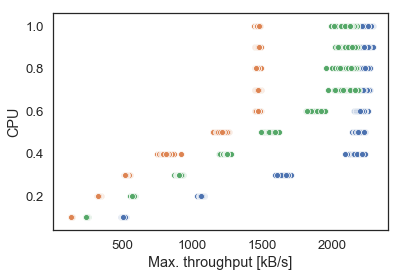

In [5]:
# plot cpu and Max. throughput [kB/s]
sns.scatterplot(web1_small['Max. throughput [kB/s]'], web1_small['CPU'])
# sns.scatterplot(web1_big['Max. throughput [kB/s]'], web1_big['CPU'])
sns.scatterplot(web2_small['Max. throughput [kB/s]'], web2_small['CPU'])
# sns.scatterplot(web2_big['Max. throughput [kB/s]'], web2_big['CPU'])
sns.scatterplot(web3_small['Max. throughput [kB/s]'], web3_small['CPU'])
# sns.scatterplot(web3_big['Max. throughput [kB/s]'], web3_big['CPU'])

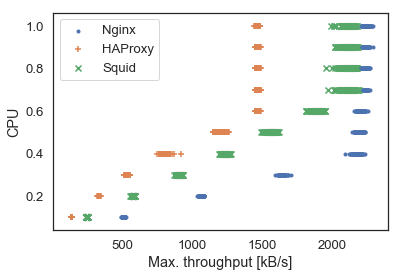

In [6]:
# proper plotting of VNF data for paper
# only use data with small flows
def plot_vnf_data():
    fig, ax = plt.subplots()
    plt.scatter(web1_small['Max. throughput [kB/s]'], web1_small['CPU'], label='Nginx', marker='.')
    plt.scatter(web2_small['Max. throughput [kB/s]'], web2_small['CPU'], label='HAProxy', marker='+')
    plt.scatter(web3_small['Max. throughput [kB/s]'], web3_small['CPU'], label='Squid', marker='x')

    # labels
    ax.set_xlabel('Max. throughput [kB/s]')
    ax.set_ylabel('CPU')
    plt.legend()
    
    fig.savefig(f'plots/web_vnf_data.pdf', bbox_inches='tight')
    
plot_vnf_data()

In [7]:
def display_scores(scores):
    print(f"Mean: {scores.mean()}")
    print(f"Std: {scores.std()}")
    
def do_cv(model, X_train, y_train, k=5):
    # train score
    print("Train score:")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    display_scores(rmse)
    
    # CV score
    print("CV score:")
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    display_scores(rmse)
    
    return rmse    
    
def check_model(X_train, y_train, model):
    """Do test, train split; k-fold CV; and visualize"""
    name = type(model).__name__
    print(f"\n{name}")
    
    rmse = do_cv(model, X_train, y_train)
#     predict_plot_all(model, X, y)

    return rmse

In [20]:
data = web3_small
vnf_name = 'web1_small'

# prepare train and test set
X = data[['Max. throughput [kB/s]']]
y = data['CPU']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmse_lin = check_model(X_train, y_train, LinearRegression())
rmse_ridge = check_model(X_train, y_train, Ridge())
rmse_svr = check_model(X_train, y_train, SVR())
rmse_forest = check_model(X_train, y_train, RandomForestRegressor())
rmse_boost = check_model(X_train, y_train, GradientBoostingRegressor())
rmse_mlp = check_model(X_train, y_train, MLPRegressor())


LinearRegression
Train score:
Mean: 0.09322233125636316
Std: 0.0
CV score:
Mean: 0.09326866997378676
Std: 0.00462386291575073

Ridge
Train score:
Mean: 0.09322233125636317
Std: 0.0
CV score:
Mean: 0.09326866997114842
Std: 0.004623862952590329

SVR
Train score:
Mean: 0.09186854853651501
Std: 0.0
CV score:
Mean: 0.1456242429087426
Std: 0.011276268469810873

RandomForestRegressor
Train score:
Mean: 0.033788920092713025
Std: 0.0
CV score:
Mean: 0.08562002575278269
Std: 0.008416689038959832

GradientBoostingRegressor
Train score:
Mean: 0.05681449243067667
Std: 0.0
CV score:
Mean: 0.07856240641677063
Std: 0.007032525379013144

MLPRegressor
Train score:
Mean: 0.13479830631840642
Std: 0.0
CV score:
Mean: 0.1201319980932457
Std: 0.02252172698141628


In [21]:
# bar plot comparing the RMSE of the different algorithms
def barplot_rmse(scores, labels, data_name):
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots()
    plt.bar(x, rmse_mean, color='grey', yerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('Machine learning models')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

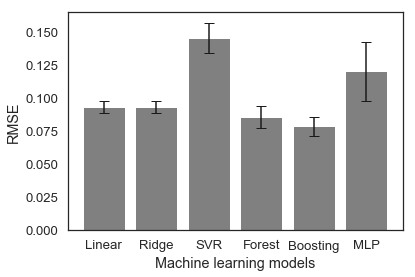

In [22]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP']
scores = [rmse_lin, rmse_ridge, rmse_svr, rmse_forest, rmse_boost, rmse_mlp]

barplot_rmse(scores, labels, vnf_name)

In [23]:
def predict_plot_all(models, X, y, vnf_name):
    """Given a list of models, fit all to the data, save model, and plot their predictions"""
    plt.scatter(X, y, label='True')
    for model in models:
        name = type(model).__name__
        model.fit(X, y)
        joblib.dump(model, f'ml_models/{vnf_name}/{name}.joblib')
        y_pred = model.predict(X)
        plt.scatter(X, y_pred, label=name)
    plt.xlabel('Max. throughput [kB/s]')
    plt.ylabel('CPU')
    plt.legend()

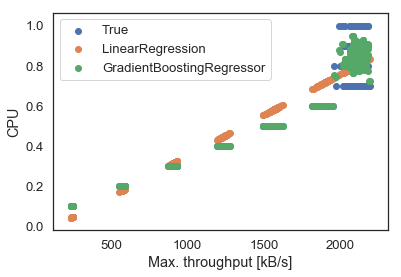

In [24]:
predict_plot_all([LinearRegression(), GradientBoostingRegressor()], X, y, vnf_name)

In [13]:
# TODO: tune hyper params and check difference. probably only do this for the best model or so

# MLP
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256), (64,64,)],
    'learning_rate_init': [0.01, 0.001, 0.0001],
             }
grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# grid_search.best_estimator_
# np.sqrt(-grid_search.best_score_)

print(grid_search.best_params_)

# get CV score of best 
idx = grid_search.best_index_
score = grid_search.cv_results_['mean_test_score'][idx]
std = grid_search.cv_results_['std_test_score'][idx]
np.sqrt(-score)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


0.10021256054627607